In [1]:
## Importing necessary libraries
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

In [2]:
## Reading Files
train = pd.read_csv("PH1.csv") ## Training File
test = pd.read_csv("PHT.csv")   ## Test File
train.head(5)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [3]:
train.shape ## Shape of training set

(38932, 5)

In [4]:
test.shape ## Shape of test set

(29404, 4)

## Data Visualization

In [5]:
import seaborn as sns
import matplotlib.pyplot  as plt
import matplotlib
%matplotlib inline

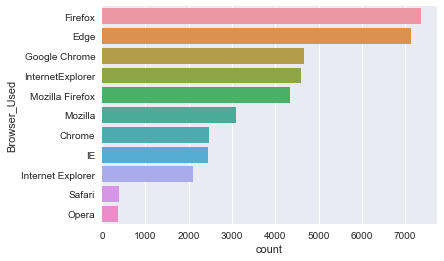

In [6]:
sns.countplot(y = "Browser_Used" , data = train , order = train["Browser_Used"].value_counts().index)
plt.figure()

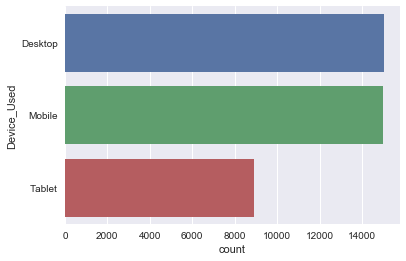

In [7]:
sns.countplot(y = "Device_Used" , data = train , order = train["Device_Used"].value_counts().index)
plt.figure()

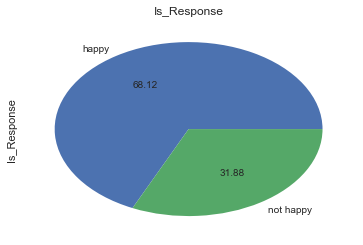

In [8]:
pd.Series(train["Is_Response"]).value_counts().plot(kind = "pie" , title = "Is_Response" , autopct='%.2f')
plt.figure()

## Data Pre-Processing

In [9]:
# function to clean data

stops = set(stopwords.words("english"))
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

In [10]:
## join data
test['Is_Response'] = np.nan
alldata = pd.concat([train, test]).reset_index(drop=True)

In [11]:
# clean description
train['Description'] = train['Description'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True))

In [12]:
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,1), min_df = 20, max_features=3500) ## Using Tf-idf

In [13]:
tfidfdata = tfidfvec.fit_transform(alldata['Description'])

In [14]:
cols = ['Browser_Used','Device_Used']

for x in cols:
    lbl = LabelEncoder()
    alldata[x] = lbl.fit_transform(alldata[x])

In [15]:
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [16]:
tfidf_df.columns = ['col' + str(x) for x in tfidf_df.columns]

In [17]:
tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

In [18]:
train_feats = alldata[~pd.isnull(alldata.Is_Response)]
test_feats = alldata[pd.isnull(alldata.Is_Response)]

In [19]:
train_feats['Is_Response'] = [1 if x == 'happy' else 0 for x in train_feats['Is_Response']]

C:\Users\Akshay\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
train_feats2 = pd.concat([train_feats[cols], tfid_df_train], axis=1)
test_feats2 = pd.concat([test_feats[cols], tfid_df_test], axis=1)

In [21]:
target = train_feats['Is_Response']

## Modelling

In [22]:
import sklearn
from sklearn import metrics
# import metrics we'll need
from sklearn.metrics import accuracy_score  
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc

In [23]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = sklearn.cross_validation.train_test_split(train_feats2, target, test_size = 0.20)

C:\Users\Akshay\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the estimator
knn = KNeighborsClassifier(n_neighbors=10)
print(knn)
# fit the model
knn.fit(Xtrain, ytrain)

# predict the response
y_pred = knn.predict(Xtest)

# accuracy score
pred_knn = metrics.accuracy_score(ytest, y_pred)
print ("Accuracy for KNN: {}".format(pred_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
Accuracy for KNN: 0.75343521253371


In [25]:
confusion_matrix(ytest, y_pred)

array([[1811,  701],
       [1219, 4056]])

In [26]:
print (classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       0.60      0.72      0.65      2512
          1       0.85      0.77      0.81      5275

avg / total       0.77      0.75      0.76      7787



In [27]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

In [28]:
# disable warnings from printing
from warnings import filterwarnings                                                              
filterwarnings('ignore')

# for visualizations
import seaborn
import seaborn as sns
#import ggplot
#from ggplot import *
import matplotlib as mpl
import matplotlib.pyplot as plt
% config InlineBackend.figure_format = 'png'
# allow plots to appear within the notebook
% matplotlib inline

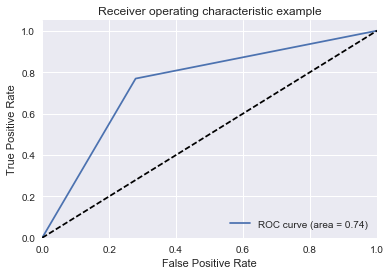

In [29]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [30]:
# import the model
from sklearn.linear_model import LogisticRegression

# instantiate the estimator
log = LogisticRegression(penalty='l1',max_iter=200)
print(log)

# fit the model
log.fit(Xtrain, ytrain)

# predict the response
y_pred = log.predict(Xtest)

# accuracy score
pred_logreg = metrics.accuracy_score(ytest, y_pred)
print ("Accuracy for Logistic Regression: {}".format(pred_logreg))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy for Logistic Regression: 0.888403749839476


In [31]:
confusion_matrix(ytest, y_pred)

array([[1988,  524],
       [ 345, 4930]])

In [32]:
print (classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.79      0.82      2512
          1       0.90      0.93      0.92      5275

avg / total       0.89      0.89      0.89      7787



In [33]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

In [34]:
# disable warnings from printing
from warnings import filterwarnings                                                              
filterwarnings('ignore')

# for visualizations
import seaborn
import seaborn as sns
#import ggplot
#from ggplot import *
import matplotlib as mpl
import matplotlib.pyplot as plt
% config InlineBackend.figure_format = 'png'
# allow plots to appear within the notebook
% matplotlib inline

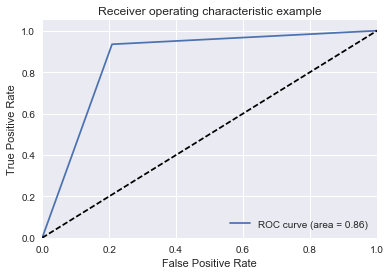

In [35]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Support Vector Machines

In [36]:
# import the model
from sklearn.svm import SVC

# instantiate the estimator
svm = SVC(C=10,gamma=.1,kernel='sigmoid')
print(svm)
# fit the model
svm.fit(Xtrain, ytrain)

# predict the response
y_pred = svm.predict(Xtest)

# accuracy score
pred_sv = metrics.accuracy_score(ytest, y_pred)
print ("Accuracy for SVM: {}".format(pred_sv))

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy for SVM: 0.6984718119943496


In [37]:
confusion_matrix(ytest, y_pred)

array([[1305, 1207],
       [1141, 4134]])

In [38]:
print (classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       0.53      0.52      0.53      2512
          1       0.77      0.78      0.78      5275

avg / total       0.70      0.70      0.70      7787



In [39]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

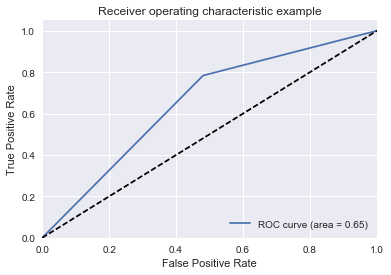

In [40]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [41]:
# import the model
from sklearn.ensemble import RandomForestClassifier

# instantiate the estimator
rf = RandomForestClassifier(n_estimators=1000)
print(rf)

# fit the model
rf.fit(Xtrain, ytrain)

# predict the response
y_pred = rf.predict(Xtest)

# accuracy score
pred_rf = metrics.accuracy_score(ytest, y_pred)
print ("Accuracy for Random Forest {}".format(pred_rf))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy for Random Forest 0.8492359059971748


In [42]:
confusion_matrix(ytest, y_pred)

array([[1486, 1026],
       [ 148, 5127]])

In [43]:
print (classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.59      0.72      2512
          1       0.83      0.97      0.90      5275

avg / total       0.86      0.85      0.84      7787



In [44]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

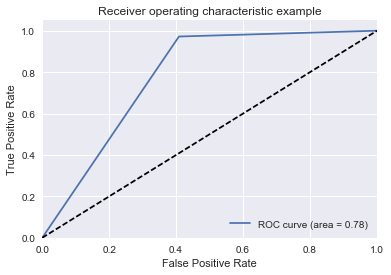

In [45]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Gaussian Naive Bayes

In [46]:
 mod1 = GaussianNB()

print(cross_val_score(mod1, Xtrain, ytrain, cv=10, scoring=make_scorer(accuracy_score)))

[ 0.81508828  0.80288925  0.81637239  0.8070626   0.81861958  0.8
  0.81824021  0.81406551  0.81278099  0.80982975]


In [47]:

mod1.fit(Xtrain, ytrain)

GaussianNB(priors=None)

In [48]:
y_pred = mod1.predict(Xtest)

# accuracy score
nv = metrics.accuracy_score(ytest, y_pred)
print ("Accuracy for Naive Bayes {}".format(nv))

Accuracy for Naive Bayes 0.8094259663541801


In [49]:
confusion_matrix(ytest,y_pred)

array([[2013,  499],
       [ 985, 4290]])

In [50]:
print(classification_report(ytest,y_pred))

             precision    recall  f1-score   support

          0       0.67      0.80      0.73      2512
          1       0.90      0.81      0.85      5275

avg / total       0.82      0.81      0.81      7787



In [51]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

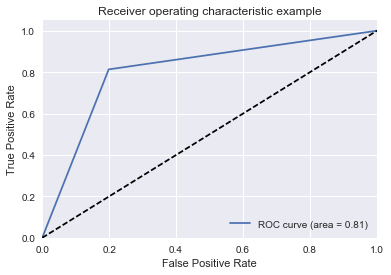

In [52]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Neural Networks (Multi Layer Perceptron)

In [53]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(1500, 400), random_state=1)

clf.fit(Xtrain, ytrain)                         

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1500, 400), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [54]:
y_pred = clf.predict(Xtest)

# accuracy score
pred_nn = metrics.accuracy_score(ytest, y_pred)
print ("Accuracy for NN {}".format(pred_nn))

Accuracy for NN 0.8918710671632207


In [55]:
confusion_matrix(ytest,y_pred)

array([[2059,  453],
       [ 389, 4886]])

In [56]:
print(classification_report(ytest,y_pred))

             precision    recall  f1-score   support

          0       0.84      0.82      0.83      2512
          1       0.92      0.93      0.92      5275

avg / total       0.89      0.89      0.89      7787



In [57]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, y_pred)

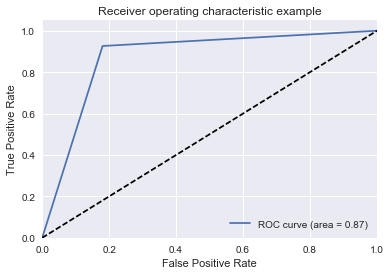

In [58]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [59]:
preds1=clf.predict(test_feats2)  ## Making predictions on the actual test set to do do submission.
preds1

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [60]:
def to_labels(x):
    if x == 1:
        return "happy"
    return "not_happy"

In [61]:
sub1 = pd.DataFrame({'User_ID':test.User_ID, 'Is_Response':preds1})
sub1['Is_Response'] = sub1['Is_Response'].map(lambda x: to_labels(x))

In [62]:
sub1 = sub1[['User_ID', 'Is_Response']]   ## Making Submission for the competition.
sub1.to_csv('nn4.csv', index=False) 

## Light GBM

In [63]:
import lightgbm as lgb

In [64]:
d_train = lgb.Dataset(Xtrain, ytrain)

In [65]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.05, 
    'max_depth': 11, 
    'num_leaves': 33, 
    'feature_fraction': 0.3, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

In [66]:
lgb_cv = lgb.cv(params, d_train, num_boost_round=500, nfold= 5, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=40)

[20]	cv_agg's binary_error: 0.177268 + 0.00433765
[40]	cv_agg's binary_error: 0.161792 + 0.00444144
[60]	cv_agg's binary_error: 0.151325 + 0.00511857
[80]	cv_agg's binary_error: 0.142398 + 0.00464358
[100]	cv_agg's binary_error: 0.136812 + 0.0054829
[120]	cv_agg's binary_error: 0.132734 + 0.00520016
[140]	cv_agg's binary_error: 0.129042 + 0.00569049
[160]	cv_agg's binary_error: 0.12628 + 0.00522587
[180]	cv_agg's binary_error: 0.124675 + 0.00422333
[200]	cv_agg's binary_error: 0.122138 + 0.00501129
[220]	cv_agg's binary_error: 0.120533 + 0.00538753
[240]	cv_agg's binary_error: 0.119538 + 0.00504394
[260]	cv_agg's binary_error: 0.118896 + 0.00506068
[280]	cv_agg's binary_error: 0.118253 + 0.00537448
[300]	cv_agg's binary_error: 0.116841 + 0.0059228
[320]	cv_agg's binary_error: 0.116134 + 0.00575152
[340]	cv_agg's binary_error: 0.115107 + 0.0054603
[360]	cv_agg's binary_error: 0.114368 + 0.00521846
[380]	cv_agg's binary_error: 0.114111 + 0.00502058
[400]	cv_agg's binary_error: 0.113309 +

In [67]:
nround = lgb_cv['binary_error-mean'].index(np.min(lgb_cv['binary_error-mean']))

In [68]:
lgbclf = lgb.train(params, d_train, num_boost_round=nround)

In [69]:
preds = lgbclf.predict(Xtest)
print(preds)

[ 0.97046368  0.97919057  0.0078904  ...,  0.92257478  0.34811045
  0.86340295]


In [87]:
def to_labels(x):
    if x > 0.50:  # cutoff - you can change it and see if accuracy improves or plot AUC curve. 
        return 1
    return 0

sub3 = pd.DataFrame({'Is_Response':preds})
sub3['Is_Response'] = sub3['Is_Response'].map(lambda x: to_labels(x))


In [88]:
#sub3 = sub3[['User_ID','Is_Response']]
#sub3.to_csv('lgb.csv', index=False) 

In [89]:
pred_llg = metrics.accuracy_score(ytest, sub3)
print ("Accuracy for LGB {}".format(pred_llg))

Accuracy for LGB 0.8913573905226659


In [90]:
confusion_matrix(ytest, sub3)

array([[1968,  544],
       [ 302, 4973]])

In [91]:
print(classification_report(ytest,sub3))

             precision    recall  f1-score   support

          0       0.87      0.78      0.82      2512
          1       0.90      0.94      0.92      5275

avg / total       0.89      0.89      0.89      7787



In [92]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, sub3)

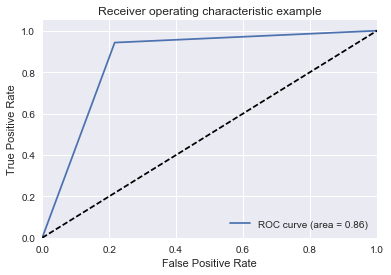

In [93]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, sub3))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Ridge Regression

In [94]:
from sklearn.linear_model import Ridge


In [95]:
clfk= Ridge(alpha=0.01)
clfk.fit(Xtrain, ytrain) 


Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [96]:
preds2 = clfk.predict(Xtest)
print(preds2)

[ 1.04675504  0.62848613 -0.16648657 ...,  0.48039556  0.27548973
  0.72007292]


In [97]:
def to_labels(z):
    if z > 0.52:  # cutoff - you can change it and see if accuracy improves or plot AUC curve. 
        return 1
    return 0

sub4 = pd.DataFrame({'Is_Response':preds2})
sub4['Is_Response'] = sub4['Is_Response'].map(lambda z: to_labels(z))


In [98]:
pred_ridge = metrics.accuracy_score(ytest, sub4)
print ("Accuracy for Ridge Regression {}".format(pred_ridge))

Accuracy for Ridge Regression 0.8754334146654681


In [99]:
confusion_matrix(ytest, sub4)

array([[1973,  539],
       [ 431, 4844]])

In [100]:
print(classification_report(ytest,sub4))

             precision    recall  f1-score   support

          0       0.82      0.79      0.80      2512
          1       0.90      0.92      0.91      5275

avg / total       0.87      0.88      0.87      7787



In [101]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(ytest, sub4)

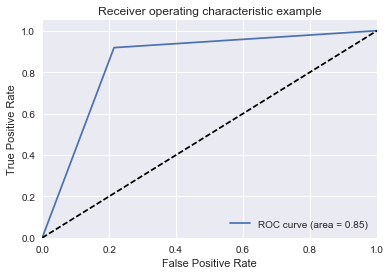

In [102]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % metrics.roc_auc_score(ytest, sub4))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()